## Exploring Particles Data

In [1]:
import numpy as np

# Loading data
loc_train = np.load('../../NRI/data/loc_train_charged5.npy')
vel_train = np.load('../../NRI/data/vel_train_charged5.npy')
edges_train = np.load('../../NRI/data/edges_train_charged5.npy')

# Sampling data for testing
sample_percentage = 0.2
loc_train = loc_train[:int(sample_percentage*loc_train.shape[0]), :-1]
vel_train = vel_train[:int(sample_percentage*vel_train.shape[0]), :-1]
edges_train = edges_train[:int(sample_percentage*edges_train.shape[0])]

print('Location shape: {}'.format(loc_train.shape))
print('Velocity shape: {}'.format(vel_train.shape))
print('Edges shape: {}'.format(edges_train.shape))

Location shape: (10000, 48, 2, 5)
Velocity shape: (10000, 48, 2, 5)
Edges shape: (10000, 5, 5)


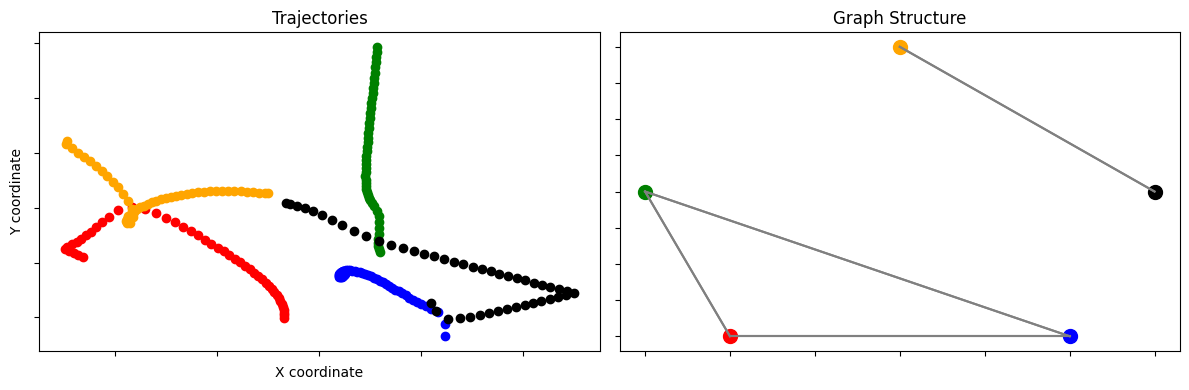

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualizing particles' trajectories
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121)
ax1.set_title('Trajectories')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax2 = fig.add_subplot(122)
ax2.set_title('Graph Structure')
ax2.set_xticklabels([])
ax2.set_yticklabels([])

rand_seq = np.random.randint(0, loc_train.shape[0])
colors = ['red', 'blue', 'green', 'orange', 'black']
edge_pos = [(0, 0), (2, 0), (-0.5, 1), (1, 2), (2.5, 1)]
for i, p, e, c in zip(range(len(edge_pos)), loc_train.swapaxes(0, 3), edge_pos, colors):
    ax1.scatter(p[:, 0, rand_seq], p[:, 1, rand_seq], color=c)
    
    ax2.scatter(e[0], e[1], color=c, s=100)
    for j in range(len(edge_pos)):
        if edges_train[rand_seq][i, j] == 1:
            ax2.plot([edge_pos[i][0], edge_pos[j][0]], [edge_pos[i][1], edge_pos[j][1]], color='grey')

plt.tight_layout()
plt.show()

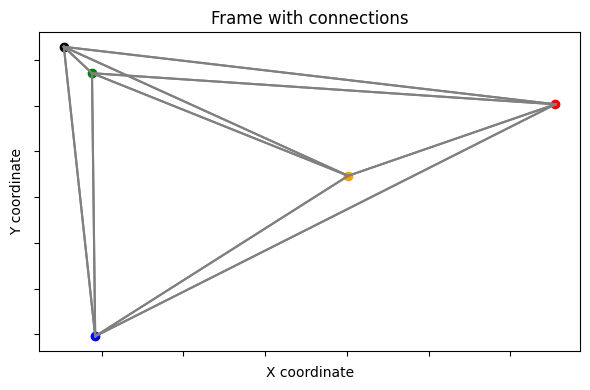

In [3]:
# Generating initial transposed edge index (adjacencies)
edge_index_t = [[i, j] for i in range(5) for j in range(5)]

# Visualizing connections for a random frame
fig = plt.figure(figsize=(6, 4))

ax1 = fig.add_subplot(111)
ax1.set_title('Frame with connections')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
ax1.set_xticklabels([])
ax1.set_yticklabels([])

rand_seq = np.random.randint(0, loc_train.shape[0])
rand_frame = np.random.randint(0, loc_train.shape[1])
colors = ['red', 'blue', 'green', 'orange', 'black']
for p, c in zip(loc_train.swapaxes(0, 3), colors):
    ax1.scatter(p[rand_frame, 0, rand_seq], p[rand_frame, 1, rand_seq], color=c)
    
for i, j in edge_index_t:
    p_ini = [loc_train[rand_seq, rand_frame, 0, i], loc_train[rand_seq, rand_frame, 0, j]]
    p_end = [loc_train[rand_seq, rand_frame, 1, i], loc_train[rand_seq, rand_frame, 1, j]]
    ax1.plot(p_ini, p_end, color='grey')

plt.tight_layout()
plt.show()

In [4]:
import torch

# Adjusting training shapes for our current architecture
train_batches = torch.cat([torch.tensor(loc_train.swapaxes(3, 2), dtype=torch.float32), \
                           torch.tensor(vel_train.swapaxes(3, 2), dtype=torch.float32)], axis=-1)

sim_len = train_batches.size(1)
seq_len = 6
train_batches = train_batches.view(-1, seq_len, train_batches.size(2), train_batches.size(3))

print('Final shape of training data: {}'.format(train_batches.shape))

# Repeating data loading process for validation data
loc_val = np.load('../../NRI/data/loc_valid_charged5.npy')
loc_val = loc_val[:int(sample_percentage*loc_val.shape[0]), :-1]

vel_val = np.load('../../NRI/data/vel_valid_charged5.npy')
vel_val = vel_val[:int(sample_percentage*vel_val.shape[0]), :-1]

edges_val = np.load('../../NRI/data/edges_valid_charged5.npy')
edge_val = edges_val[:int(sample_percentage*edges_val.shape[0])]

val_batches = torch.cat([torch.tensor(loc_val.swapaxes(3, 2), dtype=torch.float32), \
                         torch.tensor(vel_val.swapaxes(3, 2), dtype=torch.float32)], axis=-1)
val_batches = val_batches.view(-1, seq_len, val_batches.size(2), val_batches.size(3))
print('Final shape of validation data: {}'.format(val_batches.shape))

batches = torch.cat([train_batches, val_batches], axis=0)
print('Final shape of entire data: {}'.format(batches.shape))

# Sending everything to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_batches = train_batches.to(device)
val_batches = val_batches.to(device)

Final shape of training data: torch.Size([80000, 6, 5, 4])
Final shape of validation data: torch.Size([16000, 6, 5, 4])
Final shape of entire data: torch.Size([96000, 6, 5, 4])


In [5]:
# Building overlapping sequences dataset
train_batches_ovlp = torch.cat([torch.tensor(loc_train.swapaxes(3, 2), dtype=torch.float32), \
                                torch.tensor(vel_train.swapaxes(3, 2), dtype=torch.float32)], axis=-1)
train_batches_ovlp_aux = []
for sample in train_batches_ovlp:
    
    train_batches_ovlp_aux2 = []
    for start in range(sample.shape[0]-seq_len):
        train_batches_ovlp_aux2.append(sample[start:start+seq_len])

    train_batches_ovlp_aux.append(torch.stack(train_batches_ovlp_aux2))

train_batches_ovlp = torch.cat(train_batches_ovlp_aux, dim=0)
print('Final shape of training data for overlapping sequences: {}'.format(train_batches_ovlp.shape))

val_batches_ovlp = torch.cat([torch.tensor(loc_val.swapaxes(3, 2), dtype=torch.float32), \
                              torch.tensor(vel_val.swapaxes(3, 2), dtype=torch.float32)], axis=-1)
val_batches_ovlp_aux = []
for sample in val_batches_ovlp:
    
    val_batches_ovlp_aux2 = []
    for start in range(sample.shape[0]-seq_len):
        val_batches_ovlp_aux2.append(sample[start:start+seq_len])

    val_batches_ovlp_aux.append(torch.stack(val_batches_ovlp_aux2))

val_batches_ovlp = torch.cat(val_batches_ovlp_aux, dim=0)
print('Final shape of validation data for overlapping sequences: {}'.format(val_batches_ovlp.shape))

batches_ovlp = torch.cat([train_batches_ovlp, val_batches_ovlp], axis=0)
print('Final shape of entire data for overlapping sequencecs: {}'.format(batches_ovlp.shape))

train_batches_ovlp = train_batches_ovlp.to(device)
val_batches_ovlp = val_batches_ovlp.to(device)

Final shape of training data for overlapping sequences: torch.Size([420000, 6, 5, 4])
Final shape of validation data for overlapping sequences: torch.Size([84000, 6, 5, 4])
Final shape of entire data for overlapping sequencecs: torch.Size([504000, 6, 5, 4])


## Testing NRI Variant Architecture

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# Creating message passing matrices for receivers and senders - shape R^(E x N)
def message_passing_matrices(n_joints, edge_index):
    message_passing_in = torch.zeros((edge_index.size(1), n_joints))
    message_passing_out = torch.zeros((edge_index.size(1), n_joints))

    # Vectorizing message_passing matrices creation
    edge_indices = torch.arange(edge_index.size(1))
    message_passing_out[edge_indices, edge_index[0]] = 1.
    message_passing_in[edge_indices, edge_index[1]] = 1.

    return message_passing_in, message_passing_out


# NRI VAE auxiliar functions to change between nodes and edges
def node2edge(x, m_in, m_out):    
    receivers = torch.matmul(m_in, x)
    senders = torch.matmul(m_out, x)
    edges = torch.cat([senders, receivers], dim=1)
    
    return edges

def edge2node(x, m_in):
    incoming = torch.matmul(m_in.t(), x)
    
    return incoming / incoming.size(0)


# Gumbel-Softmax sampling function to allow for backpropagation with categorical distributions
def gumbel_softmax_sample(logits, temp, hard=False):
    y = F.gumbel_softmax(logits, tau=temp, hard=hard)
    
    return y


# Computing KL Divergence for categorical distribution
def gumbel_softmax_kl_divergence(logits, log_prior, batch_size):
    q_y = F.softmax(logits, dim=-1)
    kl_div = q_y * (F.log_softmax(logits, dim=-1) - log_prior)

    # Normalizing by the batch size and number of edges
    return kl_div.sum() / (batch_size * logits.size(0))


# Initializing reconstruction losses
nll_gaussian = nn.GaussianNLLLoss(reduction='mean') # Gaussian NLL
mse = nn.MSELoss(reduction='mean') # MSE


# Implementing LSTM variant with GCN layers
class gcn_lstm_cell(nn.Module):
    def __init__(self, n_in, n_out):
        super(gcn_lstm_cell, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        
        # Rebuilding LSTM cell with GCN layers
        self.gcn_i = GCNConv(n_in + n_out, n_out)
        self.gcn_f = GCNConv(n_in + n_out, n_out)
        self.gcn_o = GCNConv(n_in + n_out, n_out)
        self.gcn_g = GCNConv(n_in + n_out, n_out)

    def forward(self, x, h, c, edge_index):
        # Concatenate input and hidden state
        combined = torch.cat([x, h], dim=-1)
        
        # Compute gates
        i = torch.sigmoid(self.gcn_i(combined, edge_index))
        f = torch.sigmoid(self.gcn_f(combined, edge_index))
        o = torch.sigmoid(self.gcn_o(combined, edge_index))
        g = torch.tanh(self.gcn_g(combined, edge_index))
        
        # Compute new cell and hidden states
        c_new = f*c + i*g
        h_new = o*torch.tanh(c_new)
        
        return h_new, c_new

In [7]:
import torch_geometric.nn as geo_nn
from torch_geometric.nn import GCNConv
from torch.nn import Linear, BatchNorm1d, Dropout

# Defining NRI encoder
class nri_encoder(nn.Module):
    def __init__(self, device, n_joints, edge_index_t, n_in, n_hid, n_out, do_prob=0.):
        super(nri_encoder, self).__init__()

        # Computing edge index given transposed edge index
        self.edge_index = torch.Tensor(edge_index_t).t().long().to(device)

        # Computing the message passing matrices
        self.m_in, self.m_out = message_passing_matrices(n_joints, self.edge_index)
        self.m_in = self.m_in.to(device)
        self.m_out = self.m_out.to(device)

        # Defining the network itself interleaving GCN and MLP layers
        self.conv1 = GCNConv(n_in, n_hid, node_dim=1).to(device)
        
        self.mlp1 = Linear(n_hid*2, n_hid).to(device)
        self.bnorm1 = BatchNorm1d(n_hid).to(device)
        self.dropout1 = Dropout(do_prob).to(device)
        
        self.conv2 = GCNConv(n_hid, n_hid, node_dim=1).to(device)
        
        # self.mlp2 = Linear(n_hid*3, n_hid).to(device)
        self.mlp2 = Linear(n_hid*2, n_hid).to(device)
        self.bnorm2 = BatchNorm1d(n_hid).to(device)
        
        self.fc_out = Linear(n_hid, n_out).to(device)
        
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.1)

            elif isinstance(m, GCNConv):
                nn.init.xavier_normal_(m.lin.weight)
                m.bias.data.fill_(0.1)

    def forward(self, x):
        # Rearranging shapes: [num_seqs, num_timesteps, num_atoms, num_dims] -> [num_seqs, num_atoms, num_timesteps*num_dims]
        x = x.view(x.size(0), x.size(2), -1)

        # Forward pass interleaving GCN layers, operations to switch from nodes to edges or vice-versa, and MLP layers
        x = self.conv1(x, self.edge_index)
        x = F.relu(x)

        # edge_x = [node2edge(x_samp, self.m_in, self.m_out) for x_samp in x]
        # x = torch.stack(edge_x)
        
        # x = self.mlp1(x)
        # x = F.relu(x)

        # x = x.permute(0, 2, 1)
        # x = self.bnorm1(x)
        # x = x.permute(0, 2, 1)
        
        # x = self.dropout1(x)

        # # Skip connection
        # x_skip = x.clone()

        # node_x = [edge2node(x_samp, self.m_in) for x_samp in x]
        # x = torch.stack(node_x)
        
        x = self.conv2(x, self.edge_index)
        x = F.relu(x)
        
        edge_x = [node2edge(x_samp, self.m_in, self.m_out) for x_samp in x]
        x = torch.stack(edge_x)
        
        # x = torch.cat((x, x_skip), dim=2)
        x = self.mlp2(x)
        x = F.relu(x)

        x = x.permute(0, 2, 1)
        x = self.bnorm2(x)
        x = x.permute(0, 2, 1)

        return self.fc_out(x)

In [8]:
# NRI recurrent encoder
class nri_rec_encoder(nn.Module):
    def __init__(self, device, n_joints, edge_index_t, n_in, n_hid, n_out, do_prob=0.):
        super(nri_rec_encoder, self).__init__()
        self.device = device

        # Computing edge index given transposed edge index
        self.edge_index = torch.Tensor(edge_index_t).t().long().to(device)

        # Computing the message passing matrices
        self.m_in, self.m_out = message_passing_matrices(n_joints, self.edge_index)
        self.m_in = self.m_in.to(device)
        self.m_out = self.m_out.to(device)

        # Defining the network itself starting with GRNN and then MLP layers
        self.grnn = gcn_lstm_cell(n_in, n_hid).to(device)
        
        self.mlp1 = Linear(n_hid*2, n_hid).to(device)
        self.fc_out = Linear(n_hid, n_out).to(device)
        
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.1)

            elif isinstance(m, GCNConv):
                nn.init.xavier_normal_(m.lin.weight)
                m.bias.data.fill_(0.1)

    def forward(self, x):
        # Rearranging shapes: [num_seqs, num_timesteps, num_atoms, num_dims]
        num_seqs, num_timesteps, num_atoms, num_dims = x.shape

        # Iterating through samples in the batch
        h_batch = []
        for x_b in x:
            # Initializing cell and hidden states
            h = torch.zeros(num_atoms, self.grnn.n_out).to(self.device)
            c = torch.zeros(num_atoms, self.grnn.n_out).to(self.device)
            
            # Iterating through GRNN
            for x_t in x_b:
                h, c = self.grnn(x_t, h, c, self.edge_index)

            h_batch.append(h)
        h = torch.stack(h_batch)
        
        # Forward pass with an operation to switch from nodes to edges and MLP layers
        edge_x = [node2edge(h_samp, self.m_in, self.m_out) for h_samp in h]
        x = torch.stack(edge_x)
        
        x = self.mlp1(x)
        x = F.relu(x)

        return self.fc_out(x)

In [9]:
# Defining NRI decoder
class nri_decoder(nn.Module):
    def __init__(self, device, n_in, n_hid, n_out, do_prob=0.):
        super(nri_decoder, self).__init__()

        # Defining the network itself interleaving GCN and MLP layers
        self.conv1 = GCNConv(n_in, n_hid).to(device)
        
        self.mlp1 = Linear(n_hid*2, n_hid).to(device)
        self.dropout1 = Dropout(do_prob).to(device)
        
        self.conv2 = GCNConv(n_hid, n_out).to(device)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.1)

            elif isinstance(m, GCNConv):
                nn.init.xavier_normal_(m.lin.weight)
                m.bias.data.fill_(0.1)

    def forward(self, x, edge_index, m_in, m_out):
        # Rearranging shapes: [num_timesteps, num_atoms, num_dims] -> [num_atoms, num_timesteps*num_dims]
        x = x.view(x.size(0), x.size(2), -1)

        # Forward pass interleaving GCN layers, operations to switch from nodes to edges or vice-versa, and MLP layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = node2edge(x, m_in, m_out)
        
        x = self.mlp1(x)
        x = F.relu(x)

        x = self.dropout1(x)

        x = edge2node(x, m_in)
        
        x = self.conv2(x, edge_index)

        return x

In [10]:
# NRI recurrent decoder
class nri_rec_decoder(nn.Module):
    def __init__(self, device, n_in, n_hid, n_out, do_prob=0.):
        super(nri_rec_decoder, self).__init__()
        self.device = device
        
        # Defining the network itself starting with GRNN and then interleaving MLP and GCN layers
        self.grnn = gcn_lstm_cell(n_in, n_hid).to(device)
        
        self.mlp1 = Linear(n_hid*2, n_hid).to(device)
        self.dropout1 = Dropout(do_prob).to(device)
        
        self.conv1 = GCNConv(n_hid, n_out).to(device)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.1)

            elif isinstance(m, GCNConv):
                nn.init.xavier_normal_(m.lin.weight)
                m.bias.data.fill_(0.1)

    def forward(self, x, edge_index, m_in, m_out):
        # [num_timesteps, num_atoms, num_dims]
        num_timesteps, num_atoms, num_dims = x.shape
        
        # Initializing cell and hidden states
        h = torch.zeros(num_atoms, self.grnn.n_out).to(self.device)
        c = torch.zeros(num_atoms, self.grnn.n_out).to(self.device)
        
        # Iterating through GRNN
        for x_t in x:
            h, c = self.grnn(x_t, h, c, edge_index)

        # Forward pass interleaving GCN layers, operations to switch from nodes to edges or vice-versa, and MLP layers
        x = node2edge(h, m_in, m_out)
        
        x = self.mlp1(x)
        x = F.relu(x)

        x = self.dropout1(x)

        x = edge2node(x, m_in)
        
        x = self.conv1(x, edge_index)

        return x

In [11]:
# Defining NRI VAE
class nri_vae(nn.Module):
    def __init__(self, device, n_joints, edge_index_t, n_in, n_hid, edge_types, n_out, tau, hard, do_prob=0., n_dims=6, num_cells=None):
        super(nri_vae, self).__init__()

        # Initializing encoder and decoder
        if num_cells is None:
            self.encoder = nri_encoder(device, n_joints, edge_index_t, n_in, n_hid, edge_types, do_prob)
            self.decoder = nri_decoder(device, n_in, n_hid, n_out, do_prob)
        else:
            self.encoder = nri_encoder(device, n_joints, edge_index_t, n_in, n_hid, edge_types, do_prob)
            # self.encoder = nri_rec_encoder(device, n_joints, edge_index_t, n_dims, n_hid, edge_types, do_prob)
            self.decoder = nri_rec_decoder(device, n_dims, n_hid, n_out, do_prob)

        # Saving variables that will be used by the forward pass
        self.device = device
        self.n_joints = n_joints
        
        self.tau = tau
        self.hard = hard

        self.edge_index_t = torch.Tensor(edge_index_t).to(device)
    
    def forward(self, x):
        # Computing logits for edges with encoder
        logits = self.encoder(x)

        # Sampling edge index classes using Gumbel-Softmax
        y = gumbel_softmax_sample(logits, tau, hard)

        # Getting sampled edges for every element in the batch
        edge_index_dict = {i: [] for i in range(logits.size(0))}
        edge_index_classes = torch.nonzero(y[:, :, -1])
        for batch_element, edge in edge_index_classes:
            edge_index_dict[batch_element.item()].append(edge.item())

        recon_output = []
        for k, v in edge_index_dict.items():
            # Building edge_index for sampled edges
            edge_index_samp = self.edge_index_t[v].t().long()

            # Creating message passing matrices for decoder newly sampled edge index
            decoder_m_in, decoder_m_out = message_passing_matrices(self.n_joints, edge_index_samp)
            decoder_m_in = decoder_m_in.to(self.device)
            decoder_m_out = decoder_m_out.to(self.device)

            # Reconstructing sequences using decoder
            recon_output.append(self.decoder(x[k], edge_index_samp, decoder_m_in, decoder_m_out))
        
        recon_output = torch.stack(recon_output)

        return logits, recon_output

In [12]:
# Parallel implementation of NRI VAE, but not used because it barely helped
# import concurrent.futures as cf
# from threading import Lock

# class nri_vae_parallel(nn.Module):
#     def __init__(self, device, n_joints, edge_index_t, n_in, n_hid, edge_types, n_out, tau, hard, do_prob=0., n_dims=6, num_cells=None):
#         super(nri_vae_parallel, self).__init__()

#         # Initializing encoder and decoder
#         self.encoder = nri_encoder(device, n_joints, edge_index_t, n_in, n_hid, edge_types, do_prob)
        
#         if num_cells is None:
#             self.decoder = nri_decoder(device, n_in, n_hid, n_out, do_prob)
#         else:
#             self.decoder = nri_rec_decoder(device, n_dims, n_hid, n_out, do_prob)

#         # Saving variables that will be used by the forward pass
#         self.device = device
#         self.n_joints = n_joints
        
#         self.tau = tau
#         self.hard = hard

#         self.edge_index_t = torch.Tensor(edge_index_t).to(device)

#     def individual_reconstruction(self, k, v, edge_index_t, n_joints, device, decoder, x):
#         # Building edge_index for sampled edges
#         edge_index_samp = self.edge_index_t[v].t().long()

#         # Creating message passing matrices for decoder newly sampled edge index
#         decoder_m_in, decoder_m_out = message_passing_matrices(self.n_joints, edge_index_samp)
#         decoder_m_in = decoder_m_in.to(self.device)
#         decoder_m_out = decoder_m_out.to(self.device)

#         # Reconstructing sequences using decoder
#         return k, decoder(x[k], edge_index_samp, decoder_m_in, decoder_m_out)
    
#     def forward(self, x):
#         # Computing logits for edges with encoder
#         logits = self.encoder(x)

#         # Sampling edge index classes using Gumbel-Softmax
#         y = gumbel_softmax_sample(logits, tau, hard)

#         # Getting sampled edges for every element in the batch
#         edge_index_dict = {i: [] for i in range(logits.size(0))}
#         edge_index_classes = torch.nonzero(y[:, :, 1])
#         for batch_element, edge in edge_index_classes:
#             edge_index_dict[batch_element.item()].append(edge.item())

#         recon_output = {}
#         lock = Lock()

#         with cf.ThreadPoolExecutor() as executor:
#             future_to_key = {executor.submit(self.individual_reconstruction, k, v, self.edge_index_t, self.n_joints, \
#                                              self.device, self.decoder, x): k for k, v in edge_index_dict.items()}
    
#             for future in cf.as_completed(future_to_key):
#                 k, result = future.result()
#                 with lock:
#                     recon_output[k] = result

#         # Sorting by key to maintain the original order
#         recon_output_ordered = [recon_output[k] for k in sorted(recon_output.keys())]
#         recon_output = torch.stack(recon_output_ordered)
        
#         return logits, recon_output

In [13]:
import time
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

# Initializing all the hyperparameters
batch_size = batches.size(1)
seq_len_in = batches.size(1)
seq_len_out = 1
n_joints = batches.size(2)
dims = batches.size(3)

hidden_dims = 32
edge_types = 4

tau = 0.5
hard = True
dropout = 0.1
out_var = 5e-5

prior = [0.4, 0.3, 0.2, 0.1]
log_prior = torch.FloatTensor(np.log(prior)).unsqueeze(0).unsqueeze(0).to(device)

epochs = 20
lr = 5e-4
lr_decay = 6
gamma = 0.5

# Initializing model
model = nri_vae(device, n_joints, edge_index_t, seq_len_in*dims, hidden_dims, edge_types, seq_len_out*int(dims/2), \
                tau, hard, dropout, dims, seq_len_in)

# model = nri_vae_parallel(device, n_joints, edge_index_t, seq_len_in*dims, hidden_dims, edge_types, seq_len_out*int(dims/2), \
#                          tau, hard, dropout, dims, seq_len_in)

# Counting number of trainable parameters to compare to the dataset size
print('Total number of trainable parameters: {}\n'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

for n, p in model.named_parameters():
    if p.requires_grad:
        print('Layer {} has {} trainbale parameters'.format(n, p.numel()))

# Initializing optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay, gamma=gamma)

# Initializing lists to save losses across iterations
kl_train = []
recon_train = []
loss_train = []
kl_val = []
recon_val = []
loss_val = []

# Initializing variables to save best model
best_val_loss = torch.inf
best_epoch = 0

# Model iteration function
def model_iteration(model, optimizer, scheduler, batches, beta, mode='train', recon_mode='nll'):
    t = time.time()
    
    kl_aux = []
    recon_aux = []
    loss_aux = []

    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()
    
    progress = 0.
    for idx in range(batches.size(0)//batch_size - batch_size):
        if idx > progress*batches.size(0)//batch_size:
            print('Progress of training epoch: {:.1f}% in {:.2f}s'.format(progress*100, time.time()-t))
            progress += 0.1

        # Skipping last sequence of a simulation 
        if idx%(sim_len/seq_len) == seq_len-1:
            continue
        
        if mode == 'train':
            optimizer.zero_grad()
        
        batch = batches[idx*batch_size:(idx+1)*batch_size]
        
        # Non-overlapping sequences
        next_batch = batches[idx*batch_size+1:(idx+1)*batch_size+1]
        
        # # Overlapping sequences
        # next_batch = batches[(idx+1)*batch_size:(idx+2)*batch_size]

        logits, recon_output = model(batch)
        kl_loss = gumbel_softmax_kl_divergence(logits, log_prior, batch_size)
        recon_output = recon_output.view(batch_size, seq_len_out, n_joints, int(dims/2))

        if recon_mode == 'nll':
            var_tensor = torch.full(recon_output.shape, out_var, device=device)
            recon_loss = nll_gaussian(recon_output, next_batch[:, :seq_len_out, :, :int(dims/2)], var_tensor)
        
        elif recon_mode == 'mse':
            recon_loss = mse(recon_output, next_batch[:, :seq_len_out, :, :int(dims/2)])
            
        recon_loss = recon_loss / (recon_output.size(0) * recon_output.size(1) * recon_output.size(2))

        if recon_mode == 'nll':
            recon_coef = 0.001
        elif recon_mode == 'mse':
            recon_coef = 1
            
        loss = beta*kl_loss + recon_coef*recon_loss
        # loss = recon_coef*recon_loss

        if mode == 'train':
            loss.backward()
            optimizer.step()
    
        kl_aux.append(kl_loss.item())
        recon_aux.append(recon_coef*recon_loss.item())    
        loss_aux.append(loss.data.item())
        
    del batch, next_batch, logits, kl_loss, recon_loss

    kl_aux = torch.Tensor(kl_aux)
    recon_aux = torch.Tensor(recon_aux)
    loss_aux = torch.Tensor(loss_aux)
    tqdm.write(f'Epoch: {epoch + 1:04d}, '
               f'KL Loss ({mode}): {torch.mean(kl_aux):.4f}, '
               f'Reconstruction Loss ({mode}): {torch.mean(recon_aux):.4f}, '
               f'Combined Loss ({mode}): {torch.mean(loss_aux):.4f}, '
               f'time: {time.time() - t:.4f}s')

    if mode == 'train':
        scheduler.step()

    if mode == 'val':
        global best_val_loss
        global best_epoch
        
        if best_val_loss is torch.inf or torch.mean(loss_aux) < best_val_loss:    
            best_val_loss = torch.mean(loss_aux)
            best_epoch = epoch
            
            torch.save(model.state_dict(), 'best_weights/nri_particles_parameters.pt')
            tqdm.write(f'Epoch: {epoch + 1:04d}, Saving best parameters!')

    if recon_mode == 'nll':
        del var_tensor
    
    torch.cuda.empty_cache()

    return kl_aux, recon_aux, loss_aux

# Training loop
for epoch in tqdm(range(epochs), desc='Training Epochs'):
    # Beta coefficient to handle KL-Divergence vanishing gradients and balance reconstruction loss
    beta = epoch % int(epochs) / (epochs)

    kl_aux, recon_aux, loss_aux = model_iteration(model, optimizer, scheduler, train_batches, beta, 'train', 'nll')
    
    kl_train.append(torch.mean(kl_aux))
    recon_train.append(torch.mean(recon_aux))
    loss_train.append(torch.mean(loss_aux))

    del kl_aux, recon_aux, loss_aux

    with torch.no_grad():
        kl_aux, recon_aux, loss_aux = model_iteration(model, optimizer, scheduler, val_batches, beta, 'val', 'nll')
    
    kl_val.append(torch.mean(kl_aux))
    recon_val.append(torch.mean(recon_aux))
    loss_val.append(torch.mean(loss_aux))

    del kl_aux, recon_aux, loss_aux

print("Optimization Finished!")

Total number of trainable parameters: 13158

Layer encoder.conv1.bias has 32 trainbale parameters
Layer encoder.conv1.lin.weight has 768 trainbale parameters
Layer encoder.mlp1.weight has 2048 trainbale parameters
Layer encoder.mlp1.bias has 32 trainbale parameters
Layer encoder.bnorm1.weight has 32 trainbale parameters
Layer encoder.bnorm1.bias has 32 trainbale parameters
Layer encoder.conv2.bias has 32 trainbale parameters
Layer encoder.conv2.lin.weight has 1024 trainbale parameters
Layer encoder.mlp2.weight has 2048 trainbale parameters
Layer encoder.mlp2.bias has 32 trainbale parameters
Layer encoder.bnorm2.weight has 32 trainbale parameters
Layer encoder.bnorm2.bias has 32 trainbale parameters
Layer encoder.fc_out.weight has 128 trainbale parameters
Layer encoder.fc_out.bias has 4 trainbale parameters
Layer decoder.grnn.gcn_i.bias has 32 trainbale parameters
Layer decoder.grnn.gcn_i.lin.weight has 1152 trainbale parameters
Layer decoder.grnn.gcn_f.bias has 32 trainbale parameters


Training Epochs:   0%|                                                         | 0/20 [00:00<?, ?it/s]

Progress of training epoch: 0.0% in 0.55s
Progress of training epoch: 10.0% in 93.16s
Progress of training epoch: 20.0% in 186.25s
Progress of training epoch: 30.0% in 280.63s
Progress of training epoch: 40.0% in 374.92s
Progress of training epoch: 50.0% in 468.55s
Progress of training epoch: 60.0% in 562.04s
Progress of training epoch: 70.0% in 654.78s
Progress of training epoch: 80.0% in 748.59s
Progress of training epoch: 90.0% in 840.88s


Training Epochs:   0%|                                                         | 0/20 [15:33<?, ?it/s]

Epoch: 0001, KL Loss (train): 1.6296, Reconstruction Loss (train): 0.8940, Combined Loss (train): 0.8940, time: 933.9929s
Progress of training epoch: 0.0% in 0.07s
Progress of training epoch: 10.0% in 13.83s
Progress of training epoch: 20.0% in 27.54s
Progress of training epoch: 30.0% in 41.18s
Progress of training epoch: 40.0% in 54.76s
Progress of training epoch: 50.0% in 68.41s
Progress of training epoch: 60.0% in 82.02s
Progress of training epoch: 70.0% in 95.60s
Progress of training epoch: 80.0% in 109.36s
Progress of training epoch: 90.0% in 123.41s


Training Epochs:   5%|██▎                                          | 1/20 [17:51<5:39:10, 1071.10s/it]

Epoch: 0001, KL Loss (val): 2.2412, Reconstruction Loss (val): 0.9443, Combined Loss (val): 0.9443, time: 137.1015s
Epoch: 0001, Saving best parameters!
Progress of training epoch: 0.0% in 0.09s
Progress of training epoch: 10.0% in 93.00s
Progress of training epoch: 20.0% in 186.44s
Progress of training epoch: 30.0% in 278.10s
Progress of training epoch: 40.0% in 370.29s
Progress of training epoch: 50.0% in 463.24s
Progress of training epoch: 60.0% in 555.92s
Progress of training epoch: 70.0% in 648.64s
Progress of training epoch: 80.0% in 741.30s
Progress of training epoch: 90.0% in 834.50s


Training Epochs:   5%|██▎                                          | 1/20 [33:17<5:39:10, 1071.10s/it]

Epoch: 0002, KL Loss (train): 0.0128, Reconstruction Loss (train): 0.8465, Combined Loss (train): 0.8472, time: 926.6335s
Progress of training epoch: 0.0% in 0.07s
Progress of training epoch: 10.0% in 13.95s
Progress of training epoch: 20.0% in 27.58s
Progress of training epoch: 30.0% in 41.55s
Progress of training epoch: 40.0% in 55.11s
Progress of training epoch: 50.0% in 68.59s
Progress of training epoch: 60.0% in 82.15s
Progress of training epoch: 70.0% in 95.72s
Progress of training epoch: 80.0% in 109.31s
Progress of training epoch: 90.0% in 122.90s


Training Epochs:  10%|████▌                                        | 2/20 [35:34<5:19:53, 1066.30s/it]

Epoch: 0002, KL Loss (val): 0.0000, Reconstruction Loss (val): 0.8377, Combined Loss (val): 0.8377, time: 136.3040s
Epoch: 0002, Saving best parameters!
Progress of training epoch: 0.0% in 0.08s
Progress of training epoch: 10.0% in 91.26s
Progress of training epoch: 20.0% in 183.99s
Progress of training epoch: 30.0% in 278.16s
Progress of training epoch: 40.0% in 372.43s
Progress of training epoch: 50.0% in 465.30s
Progress of training epoch: 60.0% in 561.50s
Progress of training epoch: 70.0% in 654.86s
Progress of training epoch: 80.0% in 749.08s
Progress of training epoch: 90.0% in 840.49s


Training Epochs:  10%|████▌                                        | 2/20 [51:07<5:19:53, 1066.30s/it]

Epoch: 0003, KL Loss (train): 0.0000, Reconstruction Loss (train): 0.8338, Combined Loss (train): 0.8338, time: 933.5417s
Progress of training epoch: 0.0% in 0.06s
Progress of training epoch: 10.0% in 14.55s
Progress of training epoch: 20.0% in 28.71s
Progress of training epoch: 30.0% in 42.63s
Progress of training epoch: 40.0% in 56.62s
Progress of training epoch: 50.0% in 70.60s
Progress of training epoch: 60.0% in 84.91s
Progress of training epoch: 70.0% in 99.77s
Progress of training epoch: 80.0% in 114.92s
Progress of training epoch: 90.0% in 129.46s


Training Epochs:  15%|██████▊                                      | 3/20 [53:30<5:03:27, 1071.00s/it]

Epoch: 0003, KL Loss (val): 0.0000, Reconstruction Loss (val): 0.8377, Combined Loss (val): 0.8377, time: 143.0451s
Progress of training epoch: 0.0% in 0.09s
Progress of training epoch: 10.0% in 93.98s
Progress of training epoch: 20.0% in 187.36s


Training Epochs:  15%|██████▊                                      | 3/20 [57:09<5:23:54, 1143.21s/it]


KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(12, 6))

# Plotting training losses
ax1 = fig.add_subplot(231)
ax1.plot(kl_train, color='blue')

ax1 = fig.add_subplot(232)
ax1.plot(recon_train, color='blue')

ax1 = fig.add_subplot(233)
ax1.plot(loss_train, color='blue')

# Plotting validation losses
ax1 = fig.add_subplot(234)
ax1.plot(kl_val, color='orange')

ax1 = fig.add_subplot(235)
ax1.plot(recon_val, color='orange')

ax1 = fig.add_subplot(236)
ax1.plot(loss_val, color='orange')

# Adding column labels
fig.text(0.22, 0.96, 'KL Loss', ha='center', fontsize=14)
fig.text(0.53, 0.96, 'Reconstruction Loss', ha='center', fontsize=14)
fig.text(0.85, 0.96, 'Combined Loss', ha='center', fontsize=14)

# Adding row labels
fig.text(0.02, 0.73, 'Training', va='center', rotation='vertical', fontsize=14)
fig.text(0.02, 0.30, 'Validation', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

## Visualizing Results

In [25]:
# Loading best model
model.load_state_dict(torch.load('best_weights/nri_particles_parameters.pt'))

# Getting predicted edges from a chosen simulation and chosen sequence
sim_idx = 0
seq_idx = 0
idx = int(sim_len/seq_len)*sim_idx + seq_idx

n_joints = train_batches.size(2)

logits = model.encoder(train_batches[idx].unsqueeze(0)).squeeze(0)

y = gumbel_softmax_sample(logits, tau, False)

# Confidence threshold
confidence = 0.95
edge_index_classes = torch.where(y[:, -1] > confidence)[0]

# Top % edges
# percentage = 0.01
# k = int(len(edge_index_t)*percentage)
# edge_index_classes = torch.topk(y[:, -1], k)[1]

edge_index_samp = torch.Tensor(edge_index_t).to(device)[edge_index_classes].t().long()
print('Amount of edges sampled with confidence {}%: {}'.format(int(confidence*100), len(edge_index_classes)))
# print('Top {}% edges: {}'.format(int(percentage*100), len(edge_index_classes)))

# Getting reconstructed frame
decoder_m_in, decoder_m_out = message_passing_matrices(n_joints, edge_index_samp)
decoder_m_in = decoder_m_in.to(device)
decoder_m_out = decoder_m_out.to(device)

recon_output = model.decoder(train_batches[idx], \
                                 edge_index_samp, decoder_m_in, decoder_m_out)
recon_output = recon_output.view(seq_len_out, n_joints, int(dims/2)).cpu().detach().numpy()

if seq_len_out == 1:
    recon_output = recon_output.squeeze(0)

Amount of edges sampled with confidence 95%: 5


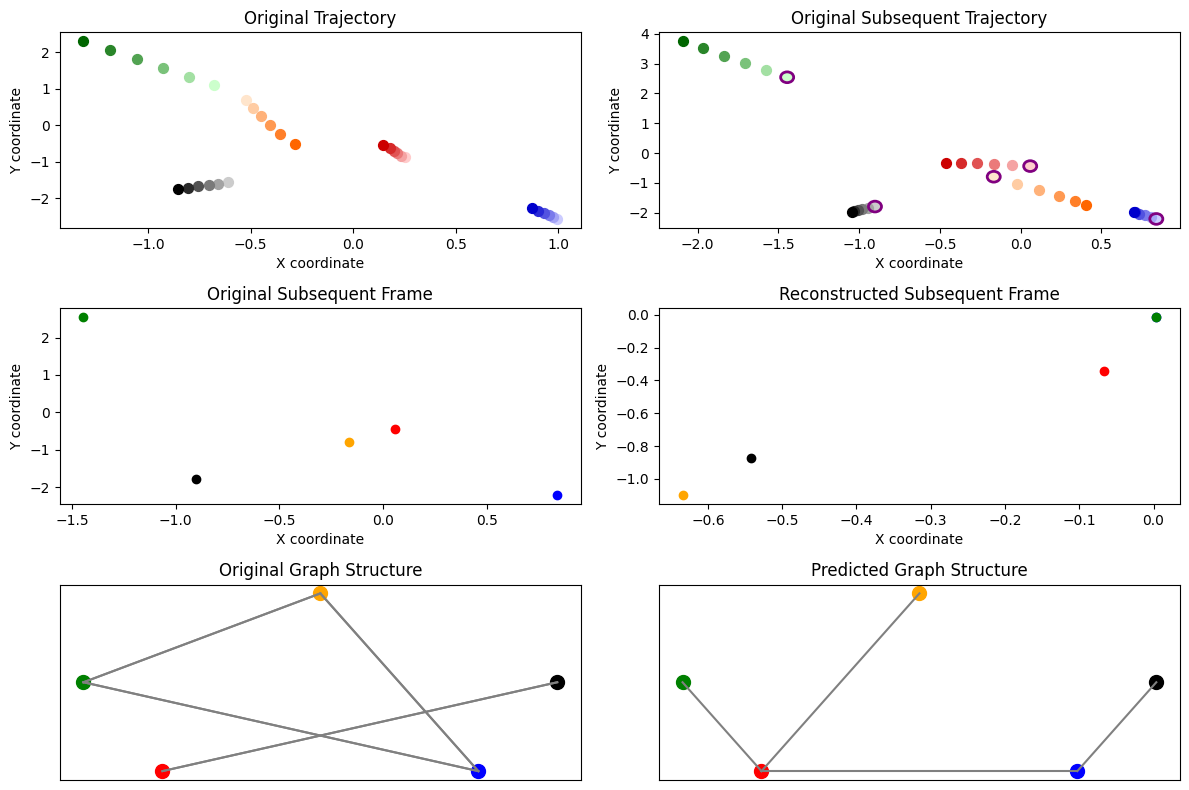

In [26]:
import matplotlib.colors as mcolors

color_scales = [
    mcolors.LinearSegmentedColormap.from_list("red_scale", ["#FFCCCC", "#CC0000"]),
    mcolors.LinearSegmentedColormap.from_list("blue_scale", ["#CCCCFF", "#0000CC"]),
    mcolors.LinearSegmentedColormap.from_list("green_scale", ["#CCFFCC", "#006600"]),
    mcolors.LinearSegmentedColormap.from_list("orange_scale", ["#FFE5CC", "#FF6600"]),
    mcolors.LinearSegmentedColormap.from_list("black_scale", ["#CCCCCC", "#000000"])
]

if seq_len_out == 1:
    fig = plt.figure(figsize=(12, 8))

    ax1 = fig.add_subplot(321)
    ax1.set_title('Original Trajectory')
    ax1.set_xlabel('X coordinate')
    ax1.set_ylabel('Y coordinate')
    
    ax2 = fig.add_subplot(322)
    ax2.set_title('Original Subsequent Trajectory')
    ax2.set_xlabel('X coordinate')
    ax2.set_ylabel('Y coordinate')
    
    ax3 = fig.add_subplot(323)
    ax3.set_title('Original Subsequent Frame')
    ax3.set_xlabel('X coordinate')
    ax3.set_ylabel('Y coordinate')
    
    ax4 = fig.add_subplot(324)
    ax4.set_title('Reconstructed Subsequent Frame')
    ax4.set_xlabel('X coordinate')
    ax4.set_ylabel('Y coordinate')
    
    ax5 = fig.add_subplot(325)
    ax5.set_title('Original Graph Structure')
    ax5.set_xticks([])
    ax5.set_yticks([])

    ax6 = fig.add_subplot(326)
    ax6.set_title('Predicted Graph Structure')
    ax6.set_xticks([])
    ax6.set_yticks([])

    # Plotting trajectories and frames
    for p, e, c, cs in zip(range(n_joints), edge_pos, colors, color_scales):
        for i in range(seq_len):
            intensity = i / (seq_len - 1)
            ax1.scatter(train_batches[idx, i, p, 0].detach().cpu(), train_batches[idx, i, p, 1].detach().cpu(), 
                        color=cs(intensity), s=50)
            ax2.scatter(train_batches[idx+1, i, p, 0].detach().cpu(), train_batches[idx+1, i, p, 1].detach().cpu(), 
                        color=cs(intensity), s=50)

        ax3.scatter(train_batches[idx+1, 0, p, 0].detach().cpu(), train_batches[idx+1, 0, p, 1].detach().cpu(), color=c)
        ax4.scatter(recon_output[p, 0], recon_output[p, 1], color=c)

        ax5.scatter(e[0], e[1], color=c, s=100)
        ax6.scatter(e[0], e[1], color=c, s=100)
        
        for j in range(n_joints):
            if edges_train[sim_idx][p, j] == 1:
                ax5.plot([edge_pos[p][0], edge_pos[j][0]], [edge_pos[p][1], edge_pos[j][1]], color='grey')

    # Plotting predicted edges
    for e in edge_index_samp.t():
        ax6.plot([edge_pos[e[0]][0], edge_pos[e[1]][0]], [edge_pos[e[0]][1], edge_pos[e[1]][1]], color='grey')

    # Highlighting points of frame to be reconstructed
    xlim = ax2.get_xlim()
    ylim = ax2.get_ylim()
    width = (xlim[1] - xlim[0]) * 0.025
    height = (ylim[1] - ylim[0]) * 0.055
    for p in range(n_joints):
        first_x = train_batches[idx+1, 0, p, 0].detach().cpu()
        first_y = train_batches[idx+1, 0, p, 1].detach().cpu()
        circle = plt.Circle((first_x, first_y), radius=1, color='purple', fill=False, linewidth=2, 
                            transform=ax2.transData)
        circle.set_width(width)
        circle.set_height(height)
        ax2.add_patch(circle)
    
    plt.tight_layout()
    plt.show()

Amount of edges sampled with confidence 95%: 2


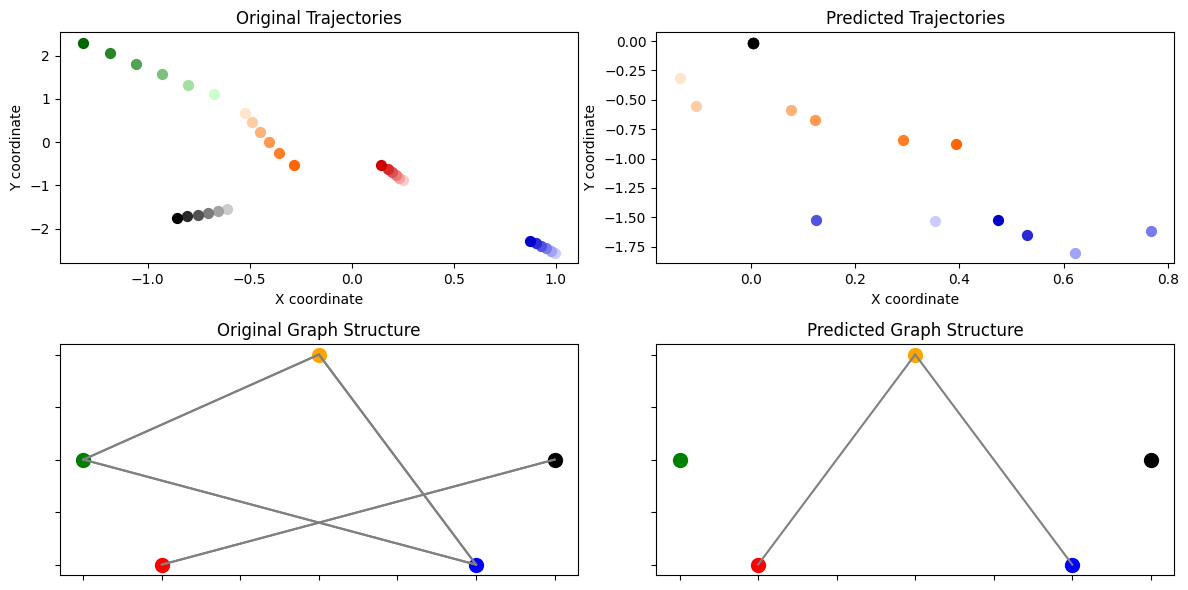

In [52]:
# Visualizing full sequence of predictions
logits = model.encoder(train_batches[idx].unsqueeze(0)).squeeze(0)

y = gumbel_softmax_sample(logits, tau, False)

# Confidence threshold
confidence = 0.95
edge_index_classes = torch.where(y[:, 1] > confidence)[0]

# Top % edges
# percentage = 0.01
# k = int(len(edge_index_t)*percentage)
# edge_index_classes = torch.topk(y[:, 1], k)[1]

edge_index_samp = torch.Tensor(edge_index_t).to(device)[edge_index_classes].t().long()
print('Amount of edges sampled with confidence {}%: {}'.format(int(confidence*100), len(edge_index_classes)))
# print('Top {}% edges: {}'.format(int(percentage*100), len(edge_index_classes)))

# Getting reconstructed frame
decoder_m_in, decoder_m_out = message_passing_matrices(n_joints, edge_index_samp)
decoder_m_in = decoder_m_in.to(device)
decoder_m_out = decoder_m_out.to(device)

recon_outputs = []
for i in range(seq_len):
    recon_output = model.decoder(train_batches_ovlp[idx+i], \
                                 edge_index_samp, decoder_m_in, decoder_m_out)
    recon_output = recon_output.view(seq_len_out, n_joints, int(dims/2))
    
    if seq_len_out == 1:
        recon_output = recon_output.squeeze(0)

    recon_outputs.append(recon_output)

recon_outputs = torch.stack(recon_outputs).cpu().detach().numpy()

# Visualizing predicted particles' trajectories and graph structure
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(221)
ax1.set_title('Original Trajectories')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')

ax2 = fig.add_subplot(222)
ax2.set_title('Predicted Trajectories')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')

ax3 = fig.add_subplot(223)
ax3.set_title('Original Graph Structure')
ax3.set_xticklabels([])
ax3.set_yticklabels([])

ax4 = fig.add_subplot(224)
ax4.set_title('Predicted Graph Structure')
ax4.set_xticklabels([])
ax4.set_yticklabels([])

# Plotting trajectories
for p, e, c, cs in zip(range(n_joints), edge_pos, colors, color_scales):
    for i in range(seq_len):
        intensity = i / (seq_len - 1)
        ax1.scatter(train_batches_ovlp[idx, i, p, 0].cpu().detach(), train_batches_ovlp[idx, i, p, 1].cpu().detach(), \
                    color=cs(intensity), s=50)
        ax2.scatter(recon_outputs[i, p, 0], recon_outputs[i, p, 1], color=cs(intensity), s=50)


    ax3.scatter(e[0], e[1], color=c, s=100)
    ax4.scatter(e[0], e[1], color=c, s=100)

    for j in range(n_joints):
        if edges_train[sim_idx][p, j] == 1:
            ax3.plot([edge_pos[p][0], edge_pos[j][0]], [edge_pos[p][1], edge_pos[j][1]], color='grey')
    
# Plotting predicted edges
for e in edge_index_samp.t():
    ax4.plot([edge_pos[e[0]][0], edge_pos[e[1]][0]], [edge_pos[e[0]][1], edge_pos[e[1]][1]], color='grey')

plt.tight_layout()
plt.show()